# Predicting Match Outcomes in League of Legends Using Early Game Stats

This project applies supervised machine learning to predict the winner of a League of Legends match using only **early-game data (first 10 minutes)**. 

I used a simulated dataset (based on Riot API) with key early-game statistics:
- Gold difference
- Kill and assist differences
- CS(Creep Score) difference
- Tower, dragon Control

Our goal: **predict whether the blue team wins**, based on these early indicators.


In [14]:
import requests
import pandas as pd
import time
import sys

API_KEY = "Insert API Here"
HEADERS = {"X-Riot-Token": API_KEY}
REGION_ROUTING = "americas"
PLATFORM_ROUTING = "na1"

SUMMONERS = [
    ("Lebron James", "0131"),
    ("Yao Ming", "BBALL"),
    ("ame", "eve"),
    ("wiiwatermelon", "na1"),
    ("salad", "1998"),
    ("pratheking", "na1"),
    ("Laceration", "Zed"),
    ("Bronny James", "bball"),
    ("Mental Clarity", "Shen"),
    ("dusklol", "000"),
]

def get_puuid(name, tag):
    url = f"https://{REGION_ROUTING}.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{name}/{tag}"
    r = requests.get(url, headers=HEADERS)
    return r.json().get("puuid") if r.status_code == 200 else None

def get_match_ids(puuid, count=20):
    url = f"https://{REGION_ROUTING}.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?start=0&count={count}&type=ranked"
    r = requests.get(url, headers=HEADERS)
    return r.json() if r.status_code == 200 else []

def get_match_data(match_id):
    url = f"https://{REGION_ROUTING}.api.riotgames.com/lol/match/v5/matches/{match_id}"
    r = requests.get(url, headers=HEADERS)
    return r.json() if r.status_code == 200 else None

def get_timeline_data(match_id, max_retries=3, delay=2.0):
    url = f"https://{REGION_ROUTING}.api.riotgames.com/lol/match/v5/matches/{match_id}/timeline"

    for attempt in range(max_retries):
        r = requests.get(url, headers=HEADERS)

        if r.status_code == 200:
            return r.json()
        elif r.status_code == 429:
            print(f"Rate limit hit for {match_id} (Attempt {attempt+1}/{max_retries}). Retrying...", flush=True)
            time.sleep(delay * 2)
        else:
            print(f"Timeline call failed for {match_id}: HTTP {r.status_code}", flush=True)
            time.sleep(delay)

    return None

def extract_10min_data(match_id):
    match = get_match_data(match_id)
    timeline = get_timeline_data(match_id)
    if not match or not timeline:
        return None

    try:
        participants = match["info"]["participants"]
        teams = match["info"]["teams"]
        frames = timeline["info"]["frames"]
        frame10 = frames[min(10, len(frames) - 1)]["participantFrames"]

        blue_ids = [p["participantId"] for p in participants if p["teamId"] == 100]
        red_ids = [p["participantId"] for p in participants if p["teamId"] == 200]

        def team_sum(ids, key):
            return sum(frame10[str(pid)][key] for pid in ids)

        def stat_diff(key):
            return team_sum(blue_ids, key) - team_sum(red_ids, key)

        kills = {"blue": 0, "red": 0}
        assists = {"blue": 0, "red": 0}
        dragons = {"blue": 0, "red": 0}
        towers = {"blue": 0, "red": 0}

        for f in frames[:11]:  # Up to 10 minutes
            for event in f.get("events", []):
                if event["type"] == "CHAMPION_KILL":
                    team = "blue" if event["killerId"] in blue_ids else "red"
                    kills[team] += 1
                    assists[team] += len(event.get("assistingParticipantIds", []))
                elif event["type"] == "ELITE_MONSTER_KILL" and event["monsterType"] == "DRAGON":
                    team = "blue" if event["killerId"] in blue_ids else "red"
                    dragons[team] += 1
                elif event["type"] == "BUILDING_KILL" and event["buildingType"] == "TOWER_BUILDING":
                    team = "blue" if event["killerId"] in blue_ids else "red"
                    towers[team] += 1

        return {
            "match_id": match_id,
            "gold_diff_10": stat_diff("totalGold"),
            "cs_diff_10": stat_diff("minionsKilled") + stat_diff("jungleMinionsKilled"),
            "kills_diff_10": kills["blue"] - kills["red"],
            "assists_diff_10": assists["blue"] - assists["red"],
            "towers_diff_10": towers["blue"] - towers["red"],
            "dragons_diff_10": dragons["blue"] - dragons["red"],
            "blue_win": int(teams[0]["win"])
        }

    except Exception as e:
        print(f"Error parsing match {match_id}: {e}", flush=True)
        return None

# === Run All Summoners ===
print("Starting summoner processing...\n", flush=True)
all_data = []

for i, (name, tag) in enumerate(SUMMONERS, 1):
    print(f"[{i}/{len(SUMMONERS)}] Looking up {name}#{tag}...", flush=True)
    puuid = get_puuid(name, tag)
    if not puuid:
        print(f"Failed to get PUUID for {name}#{tag}\n", flush=True)
        continue

    print(f"Fetching matches for {name}#{tag}...", flush=True)
    match_ids = get_match_ids(puuid, count=20)
    print(f"Found {len(match_ids)} matches.\n", flush=True)

    for idx, mid in enumerate(match_ids, 1):
        print(f"  • [{idx}/{len(match_ids)}] Extracting {mid}...", flush=True)
        row = extract_10min_data(mid)
        if row:
            all_data.append(row)
        time.sleep(2.0)

df = pd.DataFrame(all_data)
if not df.empty:
    df.to_csv("lol_earlygame_data.csv", index=False)
    print(f"\nSaved {df.shape[0]} rows, {df.shape[1]} columns", flush=True)
else:
    print("\nNo data collected.", flush=True)

df.head()


Starting summoner processing...

[1/10] Looking up Lebron James#0131...
Fetching matches for Lebron James#0131...
Found 20 matches.

  • [1/20] Extracting NA1_5283812129...
  • [2/20] Extracting NA1_5275545921...
  • [3/20] Extracting NA1_5275516124...
  • [4/20] Extracting NA1_5275498102...
  • [5/20] Extracting NA1_5275466678...
  • [6/20] Extracting NA1_5275439358...
  • [7/20] Extracting NA1_5275407721...
  • [8/20] Extracting NA1_5274220581...
  • [9/20] Extracting NA1_5274204130...
  • [10/20] Extracting NA1_5272949963...
  • [11/20] Extracting NA1_5272922361...
  • [12/20] Extracting NA1_5272155425...
  • [13/20] Extracting NA1_5272133868...
  • [14/20] Extracting NA1_5272108003...
  • [15/20] Extracting NA1_5272081819...
  • [16/20] Extracting NA1_5272063476...
  • [17/20] Extracting NA1_5272035084...
  • [18/20] Extracting NA1_5272012044...
  • [19/20] Extracting NA1_5271344060...
  • [20/20] Extracting NA1_5271316543...
[2/10] Looking up Yao Ming#BBALL...
Fetching matches for

,match_id,gold_diff_10,cs_diff_10,kills_diff_10,assists_diff_10,towers_diff_10,dragons_diff_10,blue_win
0,NA1_5283812129,487,10,1,0,0,0,1
1,NA1_5275545921,-2406,10,-7,-9,0,-1,0
2,NA1_5275516124,177,-16,3,1,0,1,1
3,NA1_5275498102,-2256,13,-4,-2,0,0,0
4,NA1_5275466678,2367,51,1,2,0,-1,1


In [15]:
import pandas as pd

df = pd.read_csv("lol_earlygame_data.csv")

print("Data shape:", df.shape)
print("Column types:\n", df.dtypes)
df.head()


Data shape: (200, 8)
Column types:
 match_id           object
gold_diff_10        int64
cs_diff_10          int64
kills_diff_10       int64
assists_diff_10     int64
towers_diff_10      int64
dragons_diff_10     int64
blue_win            int64
dtype: object


,match_id,gold_diff_10,cs_diff_10,kills_diff_10,assists_diff_10,towers_diff_10,dragons_diff_10,blue_win
0,NA1_5283812129,487,10,1,0,0,0,1
1,NA1_5275545921,-2406,10,-7,-9,0,-1,0
2,NA1_5275516124,177,-16,3,1,0,1,1
3,NA1_5275498102,-2256,13,-4,-2,0,0,0
4,NA1_5275466678,2367,51,1,2,0,-1,1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df.info())
print(df.describe())

# Win distribution
sns.countplot(data=df, x="blue_win")
plt.title("Blue Team Win Distribution")
plt.show()

# Correlation matrix (drop match_id)
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=["match_id"]).corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Drop match_id (non-numeric) and target
X = df.drop(columns=["match_id", "blue_win"])
y = df["blue_win"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

print("Logistic Regression Performance")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Performance
[[17  6]
 [ 6 11]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74        23
           1       0.65      0.65      0.65        17

    accuracy                           0.70        40
   macro avg       0.69      0.69      0.69        40
weighted avg       0.70      0.70      0.70        40



Random Forest Performance
[[18  5]
 [ 5 12]]
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        23
           1       0.71      0.71      0.71        17

    accuracy                           0.75        40
   macro avg       0.74      0.74      0.74        40
weighted avg       0.75      0.75      0.75        40



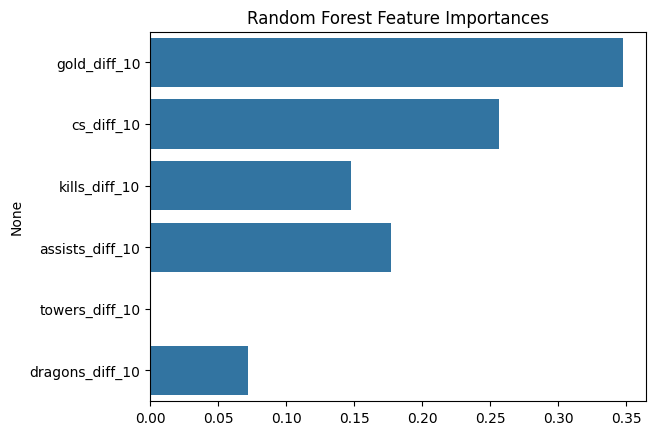

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Performance")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

sns.barplot(x=rf_model.feature_importances_, y=X.columns)
plt.title("Random Forest Feature Importances")
plt.show()


XGBoost Performance
[[17  6]
 [ 4 13]]
              precision    recall  f1-score   support

           0       0.81      0.74      0.77        23
           1       0.68      0.76      0.72        17

    accuracy                           0.75        40
   macro avg       0.75      0.75      0.75        40
weighted avg       0.76      0.75      0.75        40



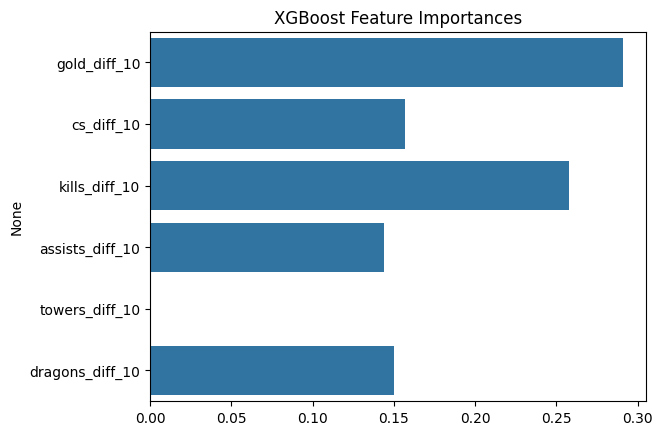

In [20]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Performance")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

sns.barplot(x=xgb_model.feature_importances_, y=X.columns)
plt.title("XGBoost Feature Importances")
plt.show()


## Summary and Observations

- All three models were able to predict game outcomes using only early-game statistics, with XGBoost and Random Forest outperforming Logistic Regression by a clear margin.
- Gold difference at 10 minutes was consistently the most important feature, confirming that early economic advantage is highly correlated with winning.
- CS difference was also a strong predictor in the tree-based models, highlighting the importance of consistent farming during the early laning phase.
- Kills and assists were moderately important but likely overlap with gold due to the way kills translate into economic and momentum advantages.
- Towers and dragons had relatively low importance in early prediction, likely because most games only have limited objective interactions by minute 10.
- Overall, results show that while early leads provide strong signals for game outcome, especially through gold and CS, full prediction still carries uncertainty due to limited information available this early in the match.